In [2]:
import datetime
import glob
import json
import multiprocessing
import numpy as np
import nomic
import os
import plotly.express as px
import sys
import time

from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv
from nomic import atlas
from PIL import Image
from tqdm import tqdm
from umap import UMAP

c:\Users\Dell\OneDrive - Northeastern University\courses\big data and intl analytics\DAMG7245-Summer2023\assignment_3\env_cv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Dell\OneDrive - Northeastern University\courses\big data and intl analytics\DAMG7245-Summer2023\assignment_3\env_cv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#de

In [50]:
# !pip install nbformat>=4.2.0

In [3]:
load_dotenv("azure.env")

key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [4]:
pyfile = "azure.py"

print("Python file:", pyfile, "Date:", time.ctime(os.path.getmtime(pyfile)))

Python file: azure.py Date: Fri Jul  7 09:37:12 2023


In [5]:
from azure import (
    image_embedding_batch,
    view_image,
)

In [6]:
sys.version

'3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]'

In [7]:
print("Today is", datetime.datetime.today())

Today is 2023-07-10 08:55:41.357670


In [8]:
IMAGES_DIR = "fashion"

In [9]:
image_files = glob.glob(IMAGES_DIR + "/*")

print("Directory of images:", IMAGES_DIR)
print("Total number of catalog images =", "{:,}".format(len(image_files)))

Directory of images: fashion
Total number of catalog images = 252


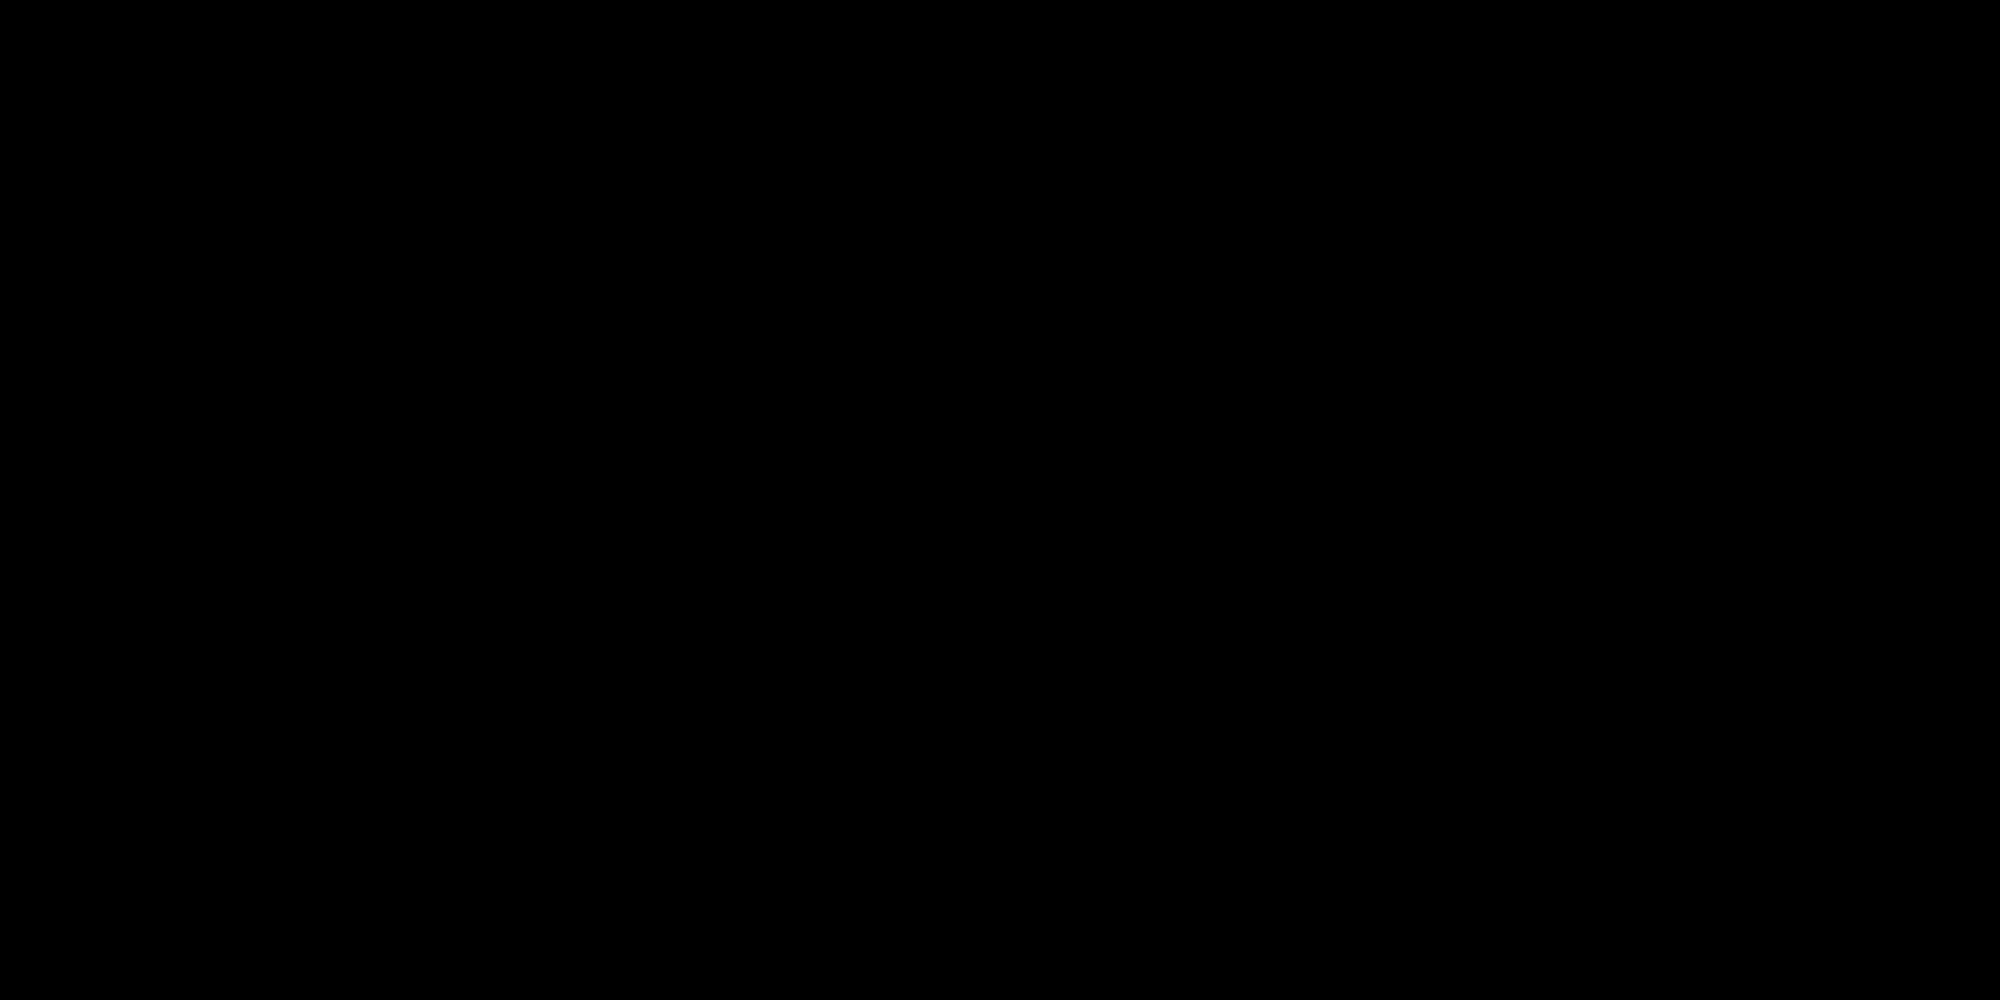

In [10]:
num_images_per_row = 10
num_images_per_col = 5
img_size = 200
start = 1000

samples = image_files[start : start + (num_images_per_row * num_images_per_col)]

samples_images = Image.new(
    "RGB", (num_images_per_row * img_size, num_images_per_col * img_size)
)

# Load and resize the images
sample_images = [
    Image.open(image_file).resize((img_size, img_size)) for image_file in samples
]

# Paste the images onto the new image
for idx, img in enumerate(sample_images):
    x = (idx % num_images_per_row) * img_size
    y = (idx // num_images_per_row) * img_size
    samples_images.paste(img, (x, y))

samples_images

In [11]:
num_cores = multiprocessing.cpu_count()

print("Number of CPU cores =", num_cores)

Number of CPU cores = 4


In [12]:
def process_image(image_file, max_retries=20):
    """
    Process image with error management
    """
    num_retries = 0

    while num_retries < max_retries:
        try:
            embedding, response = image_embedding_batch(image_file)

            if response.status_code == 200:
                return embedding

            else:
                num_retries += 1
                print(
                    f"Error processing {image_file}: {response.status_code}.\
                Retrying... (attempt {num_retries} of {max_retries})"
                )

        except Exception as e:
            print(f"An error occurred while processing {image_file}: {e}")
            print(f"Retrying... (attempt {num_retries} of {max_retries})")
            num_retries += 1

    return None

In [13]:
def process_all_images(image_files, max_workers=4, max_retries=20):
    """
    Running the full process using pool
    """
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        embeddings = list(
            tqdm(
                executor.map(lambda x: process_image(x, max_retries), image_files),
                total=len(image_files),
            )
        )

    return [emb for emb in embeddings if emb is not None]

In [14]:
print(
    datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"),
    "Starting to compute vector embeddings for our",
    "{:,}".format(len(image_files)),
    "catalog images...",
)
start = time.time()

# Running the images vector embeddings for all the images files
list_emb = process_all_images(image_files, max_workers=4, max_retries=20)

# End of job
print(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"), "Done")
elapsed = time.time() - start
print(f"\nElapsed time: {int(elapsed / 60)} minutes, {int(elapsed % 60)} seconds")
print("Number of processed images =", len(list_emb))
print(f"Processing time per image = {(elapsed / len(list_emb)):.5f} sec")

10-Jul-2023 08:55:55 Starting to compute vector embeddings for our 252 catalog images...


  0%|          | 0/252 [00:00<?, ?it/s]

 10%|▉         | 25/252 [00:03<00:30,  7.47it/s]

An error occurred while processing fashion\0399061017.jpg: 'vector'
Retrying... (attempt 0 of 20)


 23%|██▎       | 57/252 [00:07<00:19,  9.85it/s]

An error occurred while processing fashion\0620208007.jpg: 'vector'
Retrying... (attempt 0 of 20)


100%|██████████| 252/252 [00:33<00:00,  7.52it/s]

10-Jul-2023 08:56:29 Done

Elapsed time: 0 minutes, 33 seconds
Number of processed images = 252
Processing time per image = 0.13337 sec


In [15]:
print(f"Number of images files = {len(image_files)}")
print(f"Number of vectors embeddings = {len(list_emb)}")

Number of images files = 252
Number of vectors embeddings = 252


In [16]:
JSON_DIR = "json"

os.makedirs(JSON_DIR, exist_ok=True)

In [17]:
print("Exporting images vector embeddings")

# Json filename
current_dt = str(datetime.datetime.today().strftime("%d%b%Y_%H%M%S"))
json_file = os.path.join(JSON_DIR, f"img_embed_{current_dt}.json")

# Saving vectors embeddings into this Json file
with open(json_file, "w") as f:
    json.dump(list_emb, f)

print("Done. Vector embeddings have been saved in:", json_file)

Exporting images vector embeddings


Done. Vector embeddings have been saved in: json\img_embed_10Jul2023_085637.json


In [18]:
!dir $json_file

 Volume in drive C has no label.
 Volume Serial Number is 481B-396F

 Directory of c:\Users\Dell\OneDrive - Northeastern University\courses\big data and intl analytics\DAMG7245-Summer2023\assignment_3\gen-cv\azure_computer_vision_workshop\json

10-07-2023  08:56         2,984,487 img_embed_10Jul2023_085637.json
               1 File(s)      2,984,487 bytes
               0 Dir(s)  208,512,450,560 bytes free


In [21]:
# List of all Json files
json_list = [
    os.path.join(JSON_DIR, file)
    for file in os.listdir(JSON_DIR)
    if file.endswith(".json")
]

json_list

['json\\img_embed_09Jul2023_145752.json']

In [22]:
print("Importing vectors embeddings...")

JSON_DIR = "json"

jsonfiles = [entry.name for entry in os.scandir(JSON_DIR) if entry.is_file()]
jsonfiles = [f for f in jsonfiles if os.path.isfile(os.path.join(JSON_DIR, f))]

# Get the most recent file
modification_times = [
    (f, os.path.getmtime(os.path.join(JSON_DIR, f))) for f in jsonfiles
]
modification_times.sort(key=lambda x: x[1], reverse=True)
most_recent_file = JSON_DIR + "/" + modification_times[0][0]

# Loading the most recent file
print(f"Loading the most recent file of the vector embeddings: {most_recent_file}")

with open(most_recent_file) as f:
    list_emb = json.load(f)

print(f"\nDone: number of imported vector embeddings = {len(list_emb):,}")

Importing vectors embeddings...
Loading the most recent file of the vector embeddings: json/img_embed_09Jul2023_145752.json

Done: number of imported vector embeddings = 252


In [23]:
# Getting the atlas nomic key from our .env file
load_dotenv("azure.env")

atlas_nomic_key = os.getenv("atlas_nomic_key")

In [24]:
nomic.login(atlas_nomic_key)

In [25]:
datapoints = [
    {"filename": image_file_name, "id": i}
    for i, image_file_name in enumerate(image_files)
]

In [43]:
list_emb = process_all_images(image_files, max_workers=4, max_retries=20)

100%|██████████| 252/252 [00:32<00:00,  7.69it/s]


In [44]:
project = atlas.map_embeddings(
    embeddings=np.array(list_emb),  # images vector embeddings
    data=datapoints,  # datapoints
    id_field="id",  # id to be used
    name="image_file_name",  # image filename
    reset_project_if_exists=True,
    is_public=True,  # public map
)

map = project.get_map("Images vector embeddings with Azure Computer Vision 4 Florence")
print(map)

2023-07-09 18:01:11.133 | INFO     | nomic.project:__init__:665 - Found existing project `image_file_name` in organization `sukruth0402`. Clearing it of data by request.
2023-07-09 18:01:12.270 | INFO     | nomic.project:_create_project:753 - Creating project `image_file_name` in organization `sukruth0402`
2023-07-09 18:01:14.038 | INFO     | nomic.atlas:map_embeddings:107 - Uploading embeddings to Atlas.
2023-07-09 18:01:14.262 | WARNING  | nomic.project:_validate_and_correct_arrow_upload:254 - id_field is not a string. Converting to string from int32
1it [00:01,  1.65s/it]
2023-07-09 18:01:15.960 | INFO     | nomic.project:_add_data:1375 - Upload succeeded.
2023-07-09 18:01:15.971 | INFO     | nomic.atlas:map_embeddings:126 - Embedding upload succeeded.
2023-07-09 18:01:16.924 | INFO     | nomic.project:create_index:1085 - Created map `image_file_name` in project `image_file_name`: https://atlas.nomic.ai/map/f7228681-0766-4959-941e-539f72e0ed83/e8ab8b56-8c49-4bbf-9fe2-b323f839af19
20

image_file_name: https://atlas.nomic.ai/map/f7228681-0766-4959-941e-539f72e0ed83/e8ab8b56-8c49-4bbf-9fe2-b323f839af19


In [27]:
point1 = "fashion/0622271001.jpg"
point2 = "fashion/0641187002.jpg"

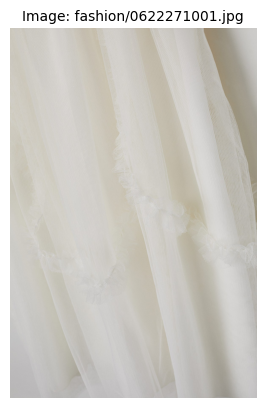

In [45]:
view_image(point1)

In [30]:
#view_image(point2)

In [46]:
print("Running Umap on the images vectors embeddings...")

start = time.time()
umap_2d = UMAP(n_components=2, init="random", random_state=0)
proj_2d = umap_2d.fit_transform(list_emb)

print("Done")
elapsed = time.time() - start
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Running Umap on the images vectors embeddings...
Done
Elapsed time: 00:00:08.532995


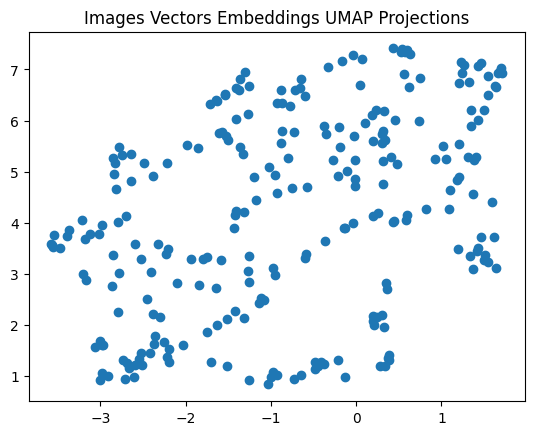

In [51]:
import matplotlib.pyplot as plt

x = proj_2d[:, 0]
y = proj_2d[:, 1]

plt.scatter(x, y)
plt.title("Images Vectors Embeddings UMAP Projections")
plt.show()

In [52]:
print("Running Umap on the images vectors embeddings...")

start = time.time()
umap_3d = UMAP(n_components=3, init="random", random_state=0)
proj_3d = umap_3d.fit_transform(list_emb)

print("Done")
elapsed = time.time() - start
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Running Umap on the images vectors embeddings...


Done
Elapsed time: 00:00:07.933007


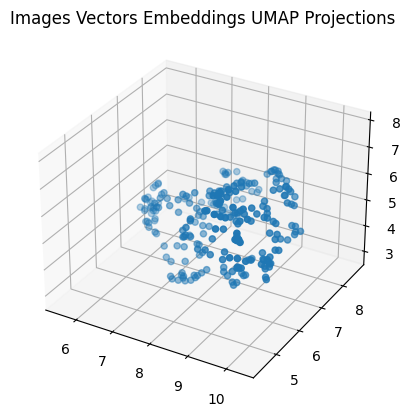

In [53]:
from mpl_toolkits.mplot3d import Axes3D

x = proj_3d[:, 0]
y = proj_3d[:, 1]
z = proj_3d[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_title("Images Vectors Embeddings UMAP Projections")
plt.show()